In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
n_cores
cluster <- makeCluster(16) 
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster,
  {
  library('survRM2')
  library('mvtnorm')
  library('survival')
  library('nph')
  library("simtrial")
  library("mdir.logrank")
  library('foreach')
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

[1] 128

# Experiments

## Single Stage ( Proportional Hazard Assumption)
#### According to Jung (2017) double arms 2 stages log rank test (page 642)   
####  $H_0 : \lambda_0 = \lambda_1 = 1.609$    
####  $H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   


------

## 1. One sided(greater) Log rank test VS Simple RMST
### 1.1 (Jung 2017 page5 example 1)
#### It is annouced that 2 sample one-sided log rank test with N = 51 per arm 
#### The power can reach 0.9 when α = 0.1. 
#### Simple RMST: Reject $H_0$ when $RMST_E - RMST_C> m_1$


The simulated alpha of one-sided log rank test is: 0.0999 
The simulated alpha of one-sided Simple RMST test is: 0.1055 
************* The empirical alpha is closed to nominated alpha 0.1 ************* 
The simulated power of one-sided log rank test is: 0.9098 
The simulated power of simple rmst test is: 0.9002

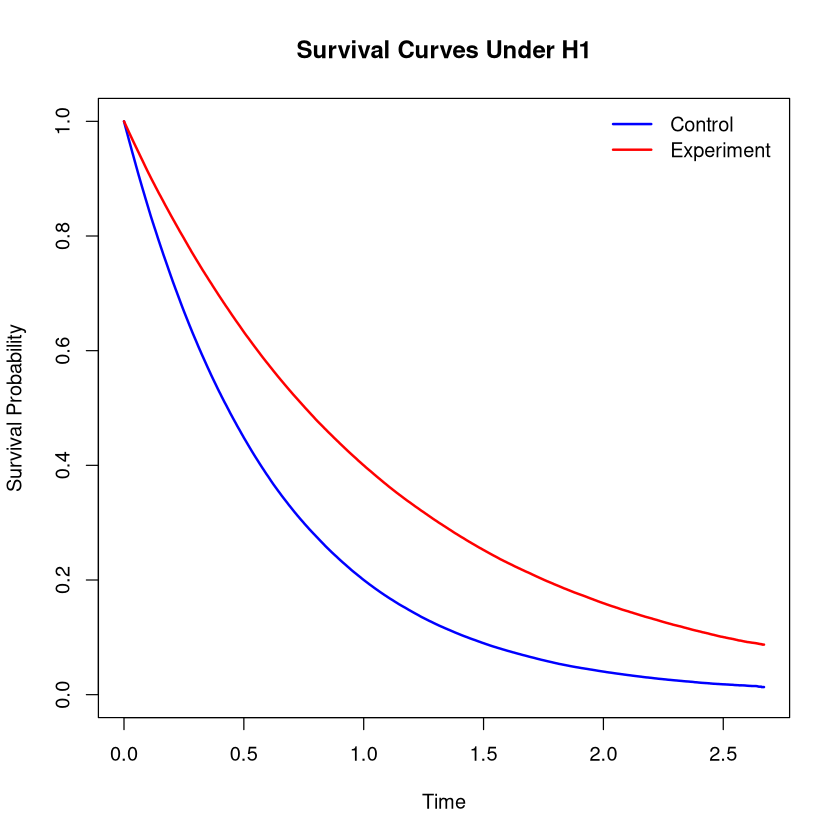

In [4]:
set.seed(2024)
sim_size = 10000
n = 51
acc_time <- 1.67
cen_time <- 1
tau <- 2

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 1.609, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = 0.916, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
# survival curve
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
# Under H0
log_rank_a <- log_rank_sim(data_C = data_C, data_E = data_E_H0, sim_size = sim_size,
                            n = n,alpha = 0.1 ,sided = 'greater')
simple_rmst_a <- RMST_sim_test(data_C = data_C, data_E = data_E_H0, sim_size = sim_size, tau = tau,
                            n = n,alpha = 0.1 ,sided = 'greater')
cat('The simulated alpha of one-sided log rank test is:', log_rank_a$rejection, '\n')
cat('The simulated alpha of one-sided Simple RMST test is:',simple_rmst_a$test_result$rejection,'\n')
cat('************* The empirical alpha is closed to nominated alpha 0.1 *************','\n')
log_rank_b <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.1 ,sided = 'greater')
simple_rmst_b <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.1 ,sided = 'greater')
cat( 'The simulated power of one-sided log rank test is:', log_rank_b$rejection,'\n')
cat('The simulated power of simple rmst test is:', simple_rmst_b$test_result$rejection)

The logrank.test function should be reliable.

### 1.2 Eaton (2020) P288 Table1 (two-sided) Scenario 1

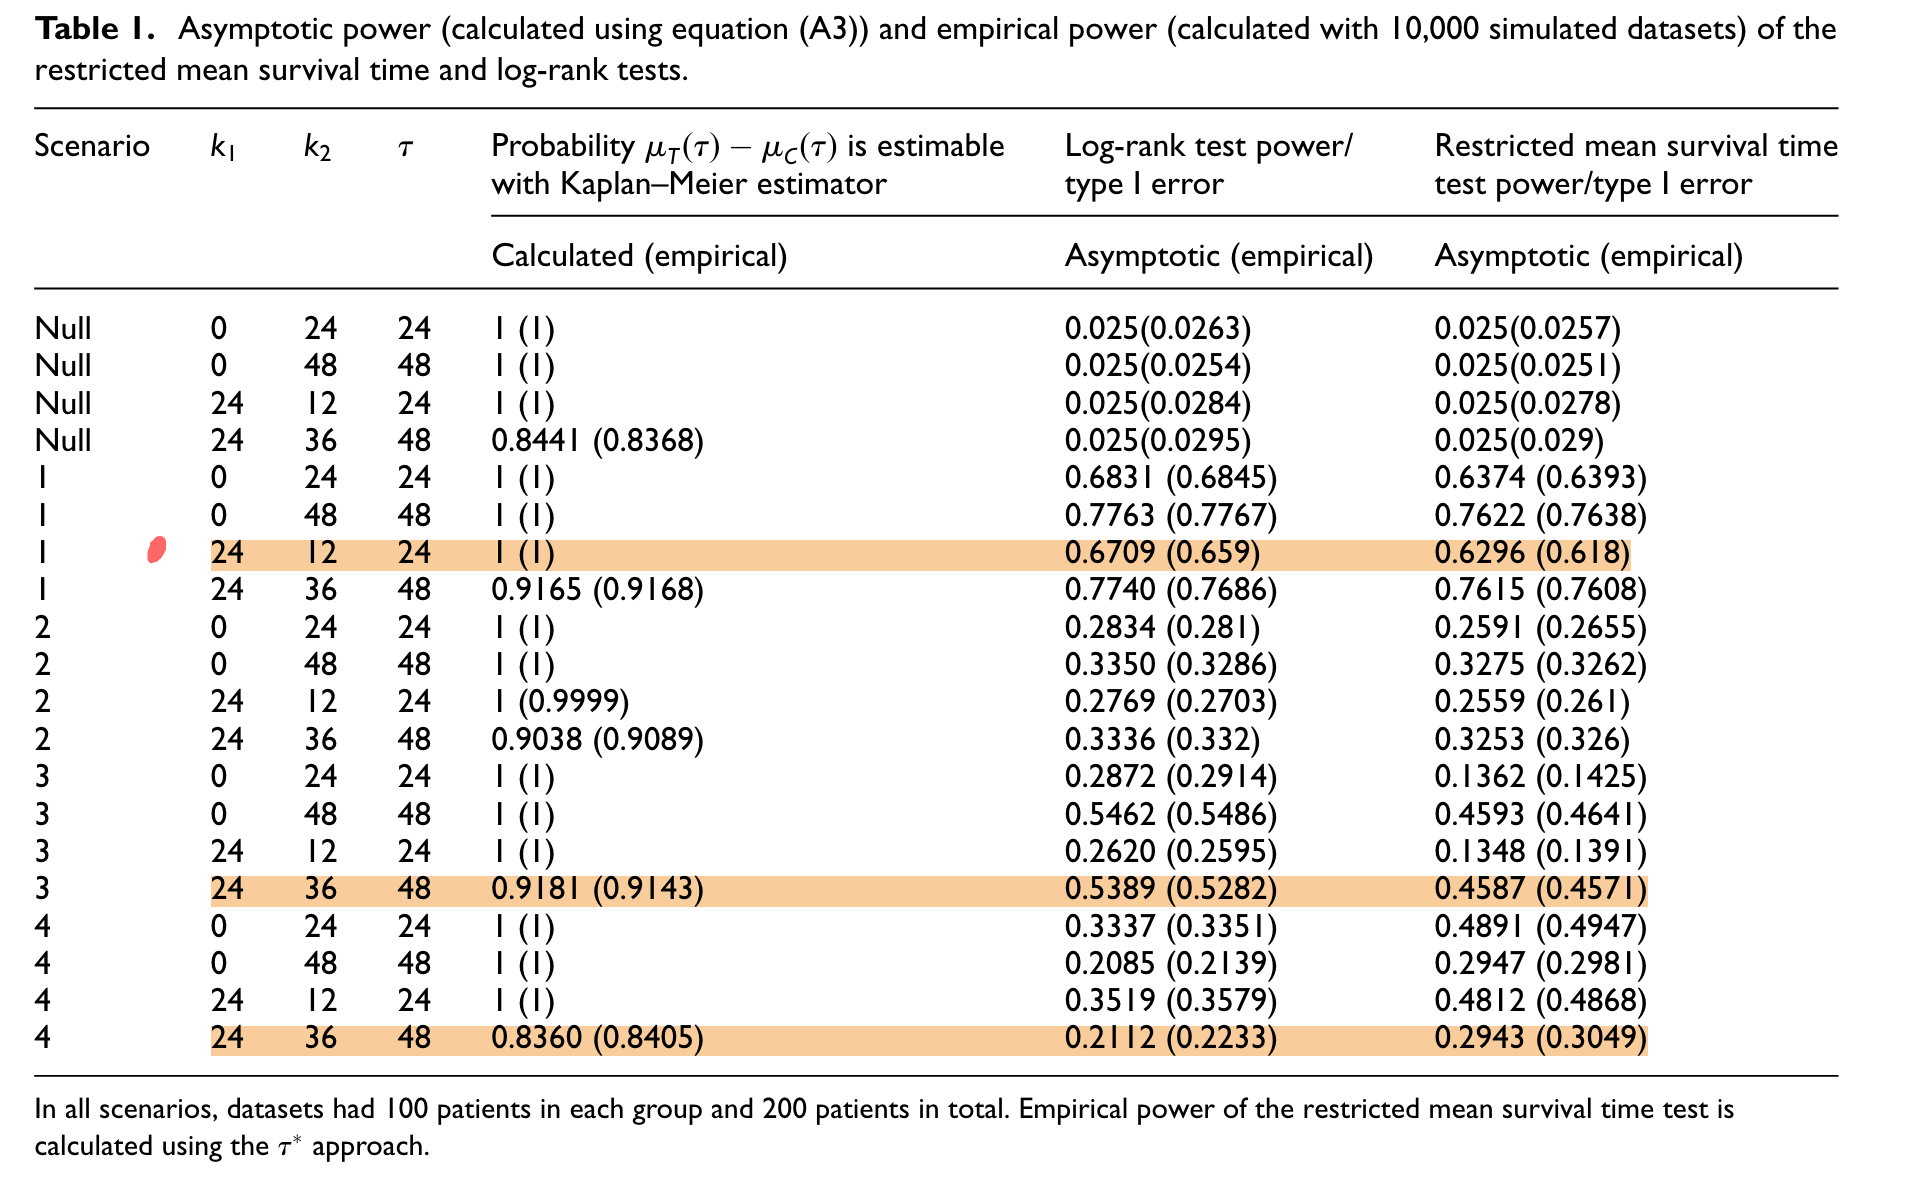

The simulated power of two-sided(alpha = 0.05) log rank test is: 0.6659 
The simulated power of two-sided(alpha = 0.05) simple rmst test is: 0.6229 
************* two sided test in Eaton 2020 *************  
The simulated power of one-sided(alpha = 0.05) log rank test is: 0.7735 
The simulated power of one-sided(alpha = 0.05) simple rmst test is: 0.7392

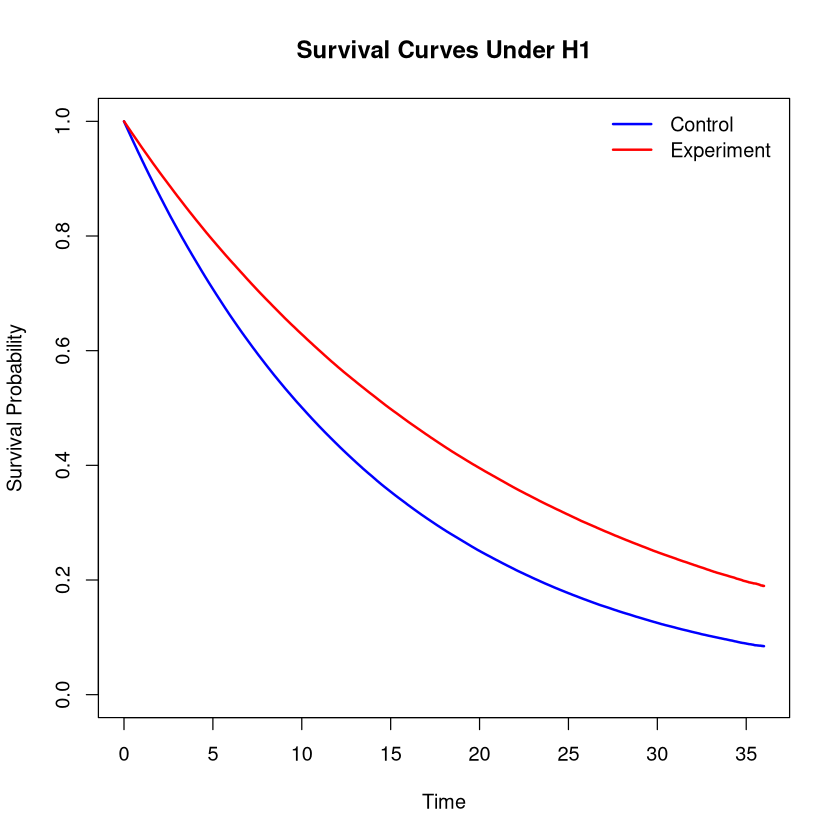

In [5]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
lambda_H1 <- lambda_H0 * 0.67
sim_size <- 10000 
acc_time <- 24
cen_time <- 12
tau <- 24
n <- 100  
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
    
# Under H1
log_rank_2 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
simple_rmst_2 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
log_rank_1 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
simple_rmst_1 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'greater')                          
display_jpeg(file='figures/Eaton_2020_table1.JPEG')
cat( 'The simulated power of two-sided(alpha = 0.05) log rank test is:', log_rank_2$rejection,'\n')
cat('The simulated power of two-sided(alpha = 0.05) simple rmst test is:', simple_rmst_2$test_result$rejection,'\n')
cat('************* two sided test in Eaton 2020 ************* ','\n')
cat( 'The simulated power of one-sided(alpha = 0.05) log rank test is:', log_rank_1$rejection,'\n')
cat('The simulated power of one-sided(alpha = 0.05) simple rmst test is:', simple_rmst_1$test_result$rejection)

## Different hazard ratio. Compare power under $\alpha = 0.05$ 
#### Ust minimax $\tau$ for simple RMST. 
#### $H_0: \lambda_E = \lambda_C = \lambda_{H0}$
#### $H_1: \lambda_C = \lambda_{H0},\ \lambda_E = \lambda_{H1}$
#### Fix $\lambda_{H0}$, change $\lambda_{H1}$

In [3]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
sim_size <- 10000 
acc_time <- 24
cen_time <- 12
tau <- 36  # Set a large tau for minimax tau 
n <- 100  
interim <- acc_time
set.seed(2024)

diff_delta_single <- foreach(HR = seq(0.5, 0.9, by = 0.05), .combine = rbind) %dopar%
    {

        lambda_H1 <- lambda_H0 * HR
        data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)
        data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)  
        data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = interim)
                            
        log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, n = n, alpha = 0.05 ,sided = 'greater')
        simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = tau, n = n, alpha = 0.05 ,sided = 'greater')

        # Monte Carlo for calculating critical value
        rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h0_int <- rmst_h0_fin                                 
        rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ ,  c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h1_int <- rmst_h1_fin 
        rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

        # Under H0
        mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
        # Under H1
        mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

        best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Complex')
        best_RMST <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                 int_n = 2 * n, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size, method = 'Simple')

        c(HR, log_rank_1$rejection, simple_rmst_1$test_result$rejection, 
            best_RMST$power, best_our$power)      
    }

In [6]:
data_C <- expo_gen_2stages(N = 100, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)
data_C

arm_all,,,,
0,5.0025676,1,5.0025676,1
0,5.0296101,0,8.4669786,1
0,1.6763304,1,1.6763304,1
0,0.4404470,1,0.4404470,1
0,2.2097883,0,6.6598547,1
0,19.3543121,0,19.4185948,1
0,7.3229740,0,29.4040050,1
0,4.9271511,1,4.9271511,1
0,15.6144436,1,15.6144436,1
0,0.4657097,0,12.0467728,1


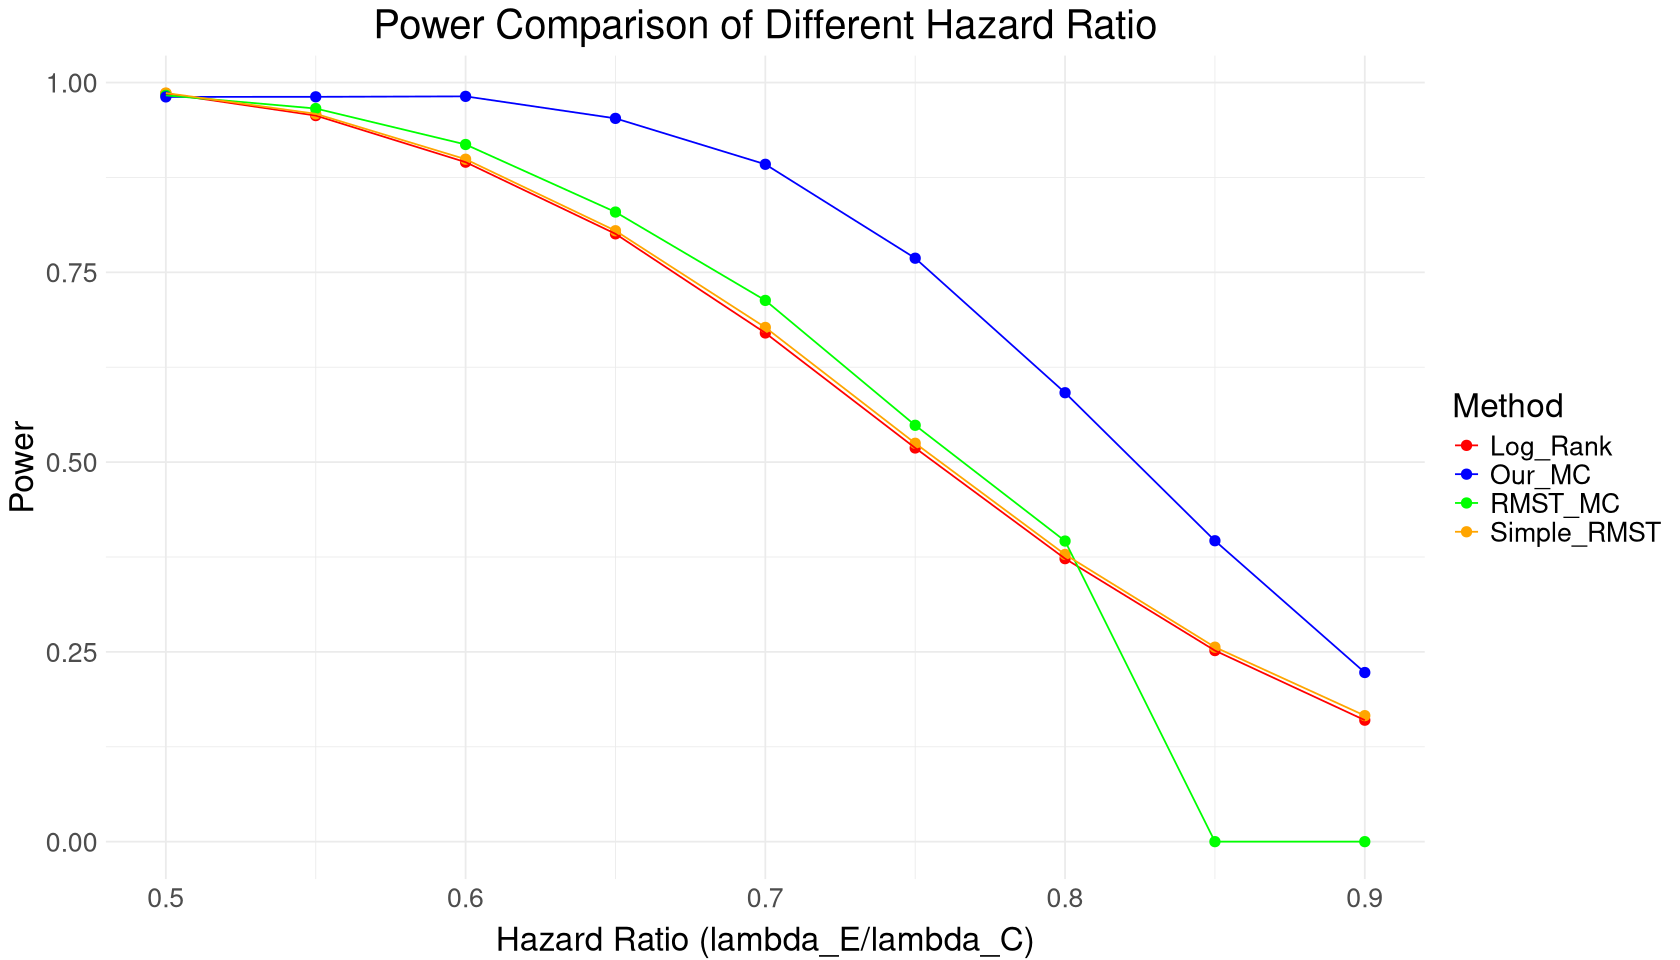

In [4]:
diff_delta_single <- data.frame(diff_delta_single)
colnames(diff_delta_single) <- c('HR','Log_Rank','Simple_RMST','RMST_MC', 'Our_MC')
diff_delta_single_long <- diff_delta_single %>% gather(key = "Method", value = "Power", -HR)
options(repr.plot.width = 14, repr.plot.height = 8)
custom_colors <- c("red", "blue", "green", "orange")
ggplot(diff_delta_single_long, aes(x = HR, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_manual(values = custom_colors) +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison of Different Hazard Ratio",
    x = "Hazard Ratio (lambda_E/lambda_C)",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

#### If we use minimax $\tau$ in RMST, the power would be almost the same as log rank
#### There is Monte Carlo error. RMST_MC would perform better but it's not true 
#### Power inflation??? The power of monte carlo should be lower than shown in the graph

-------